#**FraudRadar (Credit Card Fraud Detection)**

**Goal:** Train and evaluate a fraud detection model on the famous creditcard.csv dataset, with proper handling of class imbalance, clear evaluation, explainability (SHAP), and model export.

In [11]:
import sys, platform
print('Python:', sys.version)
print('Platform:', platform.platform())

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.6.97+-x86_64-with-glibc2.35


In [2]:
!pip -q install imbalanced-learn shap xgboost joblib

## Step 1 - Imports

In [12]:
import os, math, json, joblib, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, precision_recall_curve
)

from imblearn.over_sampling import SMOTE
import xgboost as xgb

import shap
shap.__version__

'0.48.0'

##Step 2 - Load the Dataset

In [13]:

CSV_PATH = '/content/creditcard.csv'  # if you uploaded via Files panel
df = pd.read_csv(CSV_PATH)
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


##Quick EDA & Sanity checks

In [22]:
print(df.shape)
print(df.info())
print('\nClass distribution (counts):\n', df['Class'].value_counts())
print('\nClass distribution (ratio):\n', df['Class'].value_counts(normalize=True))


(284807, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Time           284807 non-null  float64
 1   V1             284807 non-null  float64
 2   V2             284807 non-null  float64
 3   V3             284807 non-null  float64
 4   V4             284807 non-null  float64
 5   V5             284807 non-null  float64
 6   V6             284807 non-null  float64
 7   V7             284807 non-null  float64
 8   V8             284807 non-null  float64
 9   V9             284807 non-null  float64
 10  V10            284807 non-null  float64
 11  V11            284807 non-null  float64
 12  V12            284807 non-null  float64
 13  V13            284807 non-null  float64
 14  V14            284807 non-null  float64
 15  V15            284807 non-null  float64
 16  V16            284807 non-null  float64
 17  V17            2

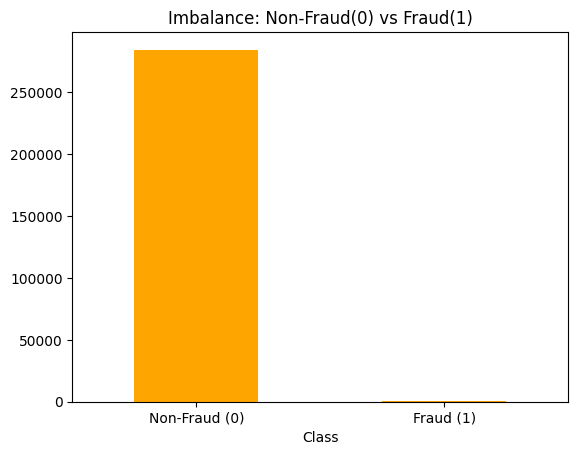

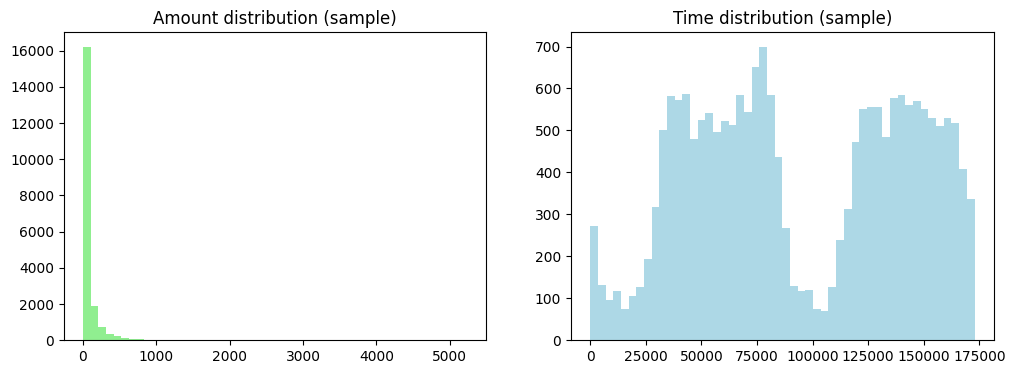

In [23]:
# Plot class imbalance
fig, ax = plt.subplots()
df['Class'].value_counts().plot(kind='bar', ax=ax, color='orange')
ax.set_title('Imbalance: Non-Fraud(0) vs Fraud(1)')
ax.set_xticklabels(['Non-Fraud (0)','Fraud (1)'], rotation=0)
plt.show()

# Distributions of Amount and Time (sample for speed)
sample = df.sample(min(20000, len(df)), random_state=42)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(sample['Amount'], bins=50, color = 'lightgreen')
axes[0].set_title('Amount distribution (sample)')
axes[1].hist(sample['Time'], bins=50, color = 'lightblue')
axes[1].set_title('Time distribution (sample)')
plt.show()

##Preprocessing - Scale AMOUNT and TIME
*We create `scaled_amount` and `scaled_time`, then drop the original columns.*

In [15]:
scaler_amount = StandardScaler()
scaler_time = StandardScaler()

df['scaled_amount'] = scaler_amount.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time']   = scaler_time.fit_transform(df['Time'].values.reshape(-1,1))

df_model = df.drop(columns=['Amount','Time'])
feature_cols = [c for c in df_model.columns if c != 'Class']
X = df_model[feature_cols].values
y = df_model['Class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((227845, 30),
 (56962, 30),
 np.float64(0.001729245759178389),
 np.float64(0.0017204452090867595))

##Handle Imbalance with SMOTE (training set only)
*We **oversample** the minority class (fraud=1) on the **training set only** using **SMOTE**.  
This avoids leaking synthetic points into the test set.*

In [16]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print('Original train size:', X_train.shape, 'fraud rate:', y_train.mean())
print('Resampled train size:', X_train_res.shape, 'fraud rate:', y_train_res.mean())

Original train size: (227845, 30) fraud rate: 0.001729245759178389
Resampled train size: (454902, 30) fraud rate: 0.5


#Train baseline Models (logictic Regression, Random Forest, XGBoost)
*We evaluate with **ROC-AUC** and **PR-AUC** (average precision) — PR-AUC is often more informative on imbalanced data.*

In [17]:
results = {}

# Logistic Regression (trained on SMOTE data)
lr = LogisticRegression(max_iter=2000, n_jobs=None)
lr.fit(X_train_res, y_train_res)
proba_lr = lr.predict_proba(X_test)[:,1]
results['LogisticRegression'] = {
    'roc_auc': roc_auc_score(y_test, proba_lr),
    'pr_auc': average_precision_score(y_test, proba_lr)
}

# Random Forest (trained on SMOTE data)
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
)
rf.fit(X_train_res, y_train_res)
proba_rf = rf.predict_proba(X_test)[:,1]
results['RandomForest'] = {
    'roc_auc': roc_auc_score(y_test, proba_rf),
    'pr_auc': average_precision_score(y_test, proba_rf)
}

# XGBoost (trained on original or SMOTE data? We'll use SMOTE for consistency)
# Another approach is to *not* use SMOTE and instead set scale_pos_weight = (neg/pos).
xgb_model = xgb.XGBClassifier(
    n_estimators=500, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
    random_state=42, n_jobs=-1, tree_method='hist'
)
xgb_model.fit(X_train_res, y_train_res, verbose=False)
proba_xgb = xgb_model.predict_proba(X_test)[:,1]
results['XGBoost'] = {
    'roc_auc': roc_auc_score(y_test, proba_xgb),
    'pr_auc': average_precision_score(y_test, proba_xgb)
}

print(pd.DataFrame(results).T.sort_values('pr_auc', ascending=False))

                     roc_auc    pr_auc
RandomForest        0.974643  0.871007
XGBoost             0.980345  0.841965
LogisticRegression  0.969848  0.724861


##Curves & Confusion Matrix at Default Threshold (0.5)

Best (by PR-AUC): RandomForest {'roc_auc': np.float64(0.9746426848736117), 'pr_auc': np.float64(0.871006719058863)}


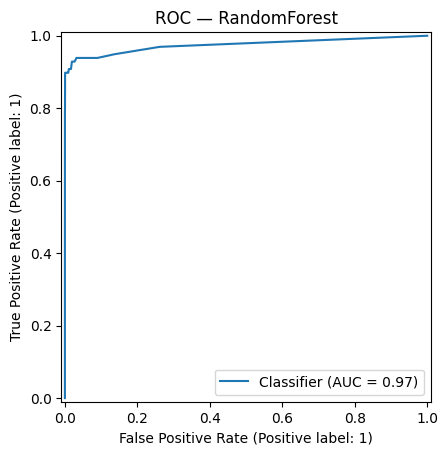

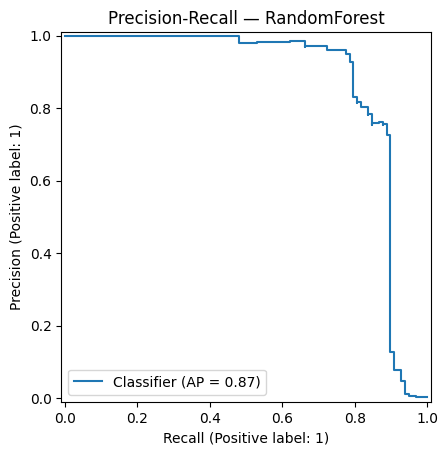

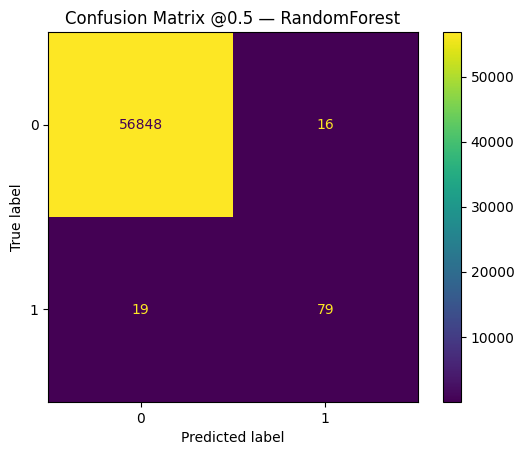

              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8316    0.8061    0.8187        98

    accuracy                         0.9994     56962
   macro avg     0.9156    0.9029    0.9092     56962
weighted avg     0.9994    0.9994    0.9994     56962



In [18]:
best_name = max(results, key=lambda k: results[k]['pr_auc'])
print('Best (by PR-AUC):', best_name, results[best_name])

proba_map = {
    'LogisticRegression': proba_lr,
    'RandomForest': proba_rf,
    'XGBoost': proba_xgb
}
best_proba = proba_map[best_name]

# ROC curve
RocCurveDisplay.from_predictions(y_test, best_proba)
plt.title(f'ROC — {best_name}')
plt.show()

# Precision-Recall curve
PrecisionRecallDisplay.from_predictions(y_test, best_proba)
plt.title(f'Precision-Recall — {best_name}')
plt.show()

# Confusion matrix at 0.5
from sklearn.metrics import ConfusionMatrixDisplay
pred_default = (best_proba >= 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, pred_default)
plt.title(f'Confusion Matrix @0.5 — {best_name}')
plt.show()

print(classification_report(y_test, pred_default, digits=4))

##Threshold tuning (optimize for Recall or F1)
**Why?** In fraud detection, missing a fraud (false negative) is costly.  
You can pick a threshold that achieves **Recall ≥ 0.90** while keeping Precision reasonable.

We’ll find two candidate thresholds:  
- **t\_f1**: maximizes F1 score  
- **t\_recall90**: smallest threshold with Recall ≥ 0.90

Best F1 threshold: 0.7533 | F1: 0.8603
Recall≥0.90 threshold: 0.0500

== Max F1 @ threshold=0.7533 ==
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9506    0.7857    0.8603        98

    accuracy                         0.9996     56962
   macro avg     0.9751    0.8928    0.9301     56962
weighted avg     0.9995    0.9996    0.9995     56962



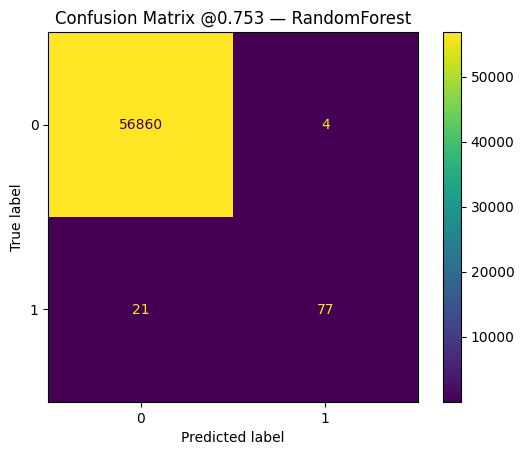


== Recall≥90% @ threshold=0.0500 ==
              precision    recall  f1-score   support

           0     0.9998    0.9893    0.9945     56864
           1     0.1271    0.9082    0.2231        98

    accuracy                         0.9891     56962
   macro avg     0.5635    0.9487    0.6088     56962
weighted avg     0.9983    0.9891    0.9932     56962



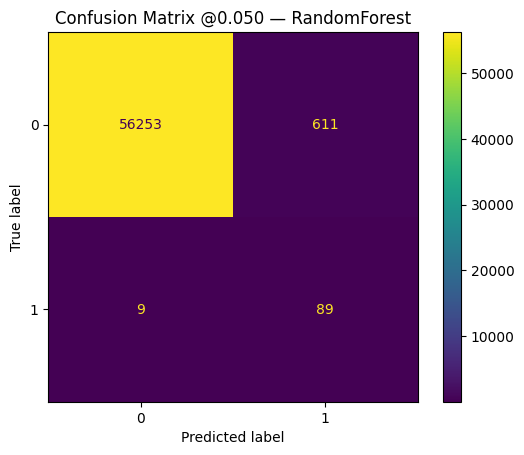

In [19]:
prec, rec, th = precision_recall_curve(y_test, best_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
ix_f1 = np.nanargmax(f1)
t_f1 = th[ix_f1] if ix_f1 < len(th) else 0.5

# Threshold for Recall >= 0.90
target_recall = 0.90
valid = np.where(rec[:-1] >= target_recall)[0]
t_recall90 = th[valid[-1]] if len(valid) else 0.5

print(f'Best F1 threshold: {t_f1:.4f} | F1: {np.nanmax(f1):.4f}')
print(f'Recall≥{target_recall:.2f} threshold: {t_recall90:.4f}')

def eval_at(thr, name):
    pred = (best_proba >= thr).astype(int)
    print(f'\n== {name} @ threshold={thr:.4f} ==')
    print(classification_report(y_test, pred, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, pred)
    plt.title(f'Confusion Matrix @{thr:.3f} — {best_name}')
    plt.show()

eval_at(t_f1, 'Max F1')
eval_at(t_recall90, f'Recall≥{target_recall:.0%}')

#Explainability with SHAP (on sample)
*We’ll compute SHAP values on a random sample for speed.  
This shows which features (like `V17`, `V14`, etc.) push predictions toward **fraud** or **non-fraud**.*

100%|===================| 5998/6000 [12:13<00:00]       

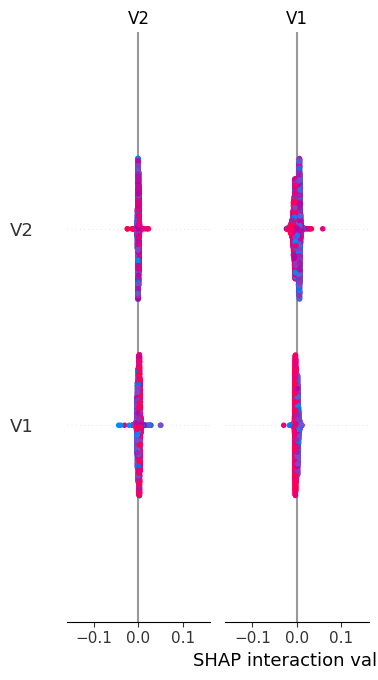

In [20]:
# Use the best model for SHAP
model_for_shap = {'LogisticRegression': lr, 'RandomForest': rf, 'XGBoost': xgb_model}[best_name]

# Convert back to DataFrame for SHAP plots with feature names
X_test_df = pd.DataFrame(X_test, columns=feature_cols)

# Sample for speed
X_shap = X_test_df.sample(min(3000, len(X_test_df)), random_state=42)

explainer = shap.Explainer(model_for_shap, X_shap)
shap_values = explainer(X_shap)

# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_shap, show=True)

Save model (for deployement later)

In [21]:
OUT_MODEL = f'/content/fraud_model_{best_name.lower()}.joblib'
joblib.dump({'model': model_for_shap, 'scaler_amount': scaler_amount, 'scaler_time': scaler_time, 'feature_cols': feature_cols}, OUT_MODEL)
OUT_MODEL

'/content/fraud_model_randomforest.joblib'